In [ ]:
import urllib.request
import pandas as pd
from osgeo import gdal, osr


import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import shapefile


from bokeh.plotting import figure, save
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper
import geopandas as gpdcolor b
import pysal as ps


from PIL import Image, ImageFilter
import cv2
import datetime
from datetime import timedelta



In [3]:
#RAIOS
from pykml import parser
import urllib.request
import numpy as np


url = 'http://www.zeus.iag.usp.br/linet/linet_0-15.kml'
file = urllib.request.urlopen(url)

folder = parser.parse(file).getroot().Document
coordList=[]
for pm in folder.Placemark:
    rawCoord = pm.Point.coordinates    
    coord = str(rawCoord).split(",")
    coordList.append(coord)

coordArray = np.array(coordList, dtype=float)
#Fazer Array de Lat e Lon, separado porimport os



MIRACATU
13.014413118362427


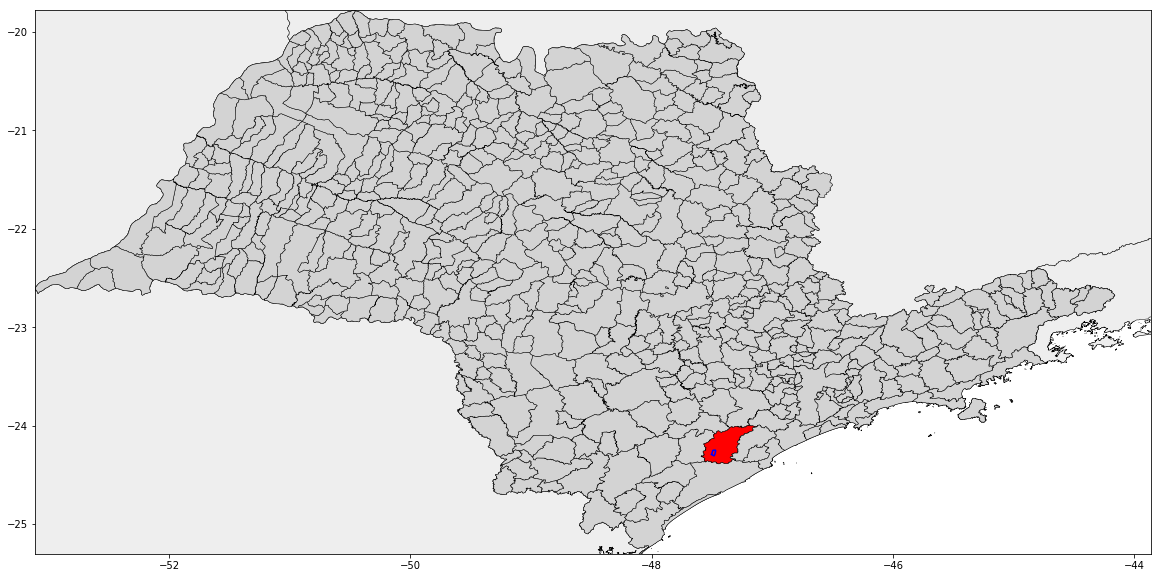

In [6]:
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
import numpy as np
import matplotlib.pyplot as plt
import time
import shapefile
from matplotlib.patches import Polygon as poli
from shapely.geometry import Polygon
from shapely.geometry import Point

def shapePatch(shape, color):
    npoints=len(shape.points) # total points
    nparts = len(shape.parts) # total parts
    if nparts == 1:
        shp = shape.points
        poligon = poli(shp, facecolor=color, edgecolor='black', linewidth=0.5)
        ax.add_patch(poligon)
    else:
        for ip in range(nparts):
            i0 = shape.parts[ip]
            if ip < nparts-1:
                i1 = shape.parts[ip+1]-1
            else:
                i1 = npoints    
            seg=shape.points[i0:i1+1]
            poligon = poli(seg, facecolor=color, edgecolor='black', linewidth=0.5)
            ax.add_patch(poligon)


start = time.time()
raio = 10000
r_d = raio/110744
buffer_ratio = (r_d)*(1-0.99919687401213+1) #Variavel que converte buffer em metros

#Cluester em DBSCAN dos pontos. de 1400 foi pra 160
db = DBSCAN(eps=0.09, min_samples=10).fit(coordArray)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique_labels = set(labels)

#Abre os arquivos shapefile do BR
fname2 = 'gadm/gadm36_BRA_2.shp'
fname1 = 'gadm/gadm36_BRA_1.shp'
fname0 = 'gadm/BRMUE250GC_SIR.shp'


sf = shapefile.Reader(fname0)
sfBr = shapefile.Reader(fname1)
shapes = sf.shapes()


fig, ax = plt.subplots(figsize=(20,10))
#Projecao do mapa
states = sfBr.shapes()
a,b,c,d = states[24].bbox
plt.xlim(a,c)
plt.ylim(b,d)
for state in states:
    shapePatch(state, '#EEEEEE') 
#Loop para todas as cidades do estado de sao paulo e passa cada ponto de dado

for city, shape in zip(sf.iterRecords(), sf.iterShapes()):
    if city[1][:2] == '35':
        cor = 'lightgray'        
        
        shape_ex = shape.points
        polygon = Polygon(shape_ex)
        
        for k in unique_labels:
            class_member_mask = (labels == k)
            if k != -1:
#----Aki sao os clusters. Usa um centroid como base e faz o buffer que cobre uma area
                xy = coordArray[class_member_mask & core_samples_mask]
                hull = ConvexHull(xy)
                TS = Polygon(xy[hull.vertices])
                ''' 
                X = np.mean(xy[:,0])
                Y = np.mean(xy[:,1])
                TS = Point(X,Y).buffer(buffer_ratio)
                '''
                if polygon.intersects(TS):
                    X, Y = TS.exterior.coords.xy
                    plt.plot(X, Y,'b')
                    print(city[0])
                    cor = 'r'
                    break
            else:
#----Aki sao os pontos isolados. E ha um array de pontos aki. Por isso o do loop interno.
                xy = coordArray[class_member_mask & ~core_samples_mask]
                for X, Y in xy:
                    point = Point(X,Y)
                    if polygon.contains(point):
                        plt.plot(X, Y, 'y*', markersize=10)
                        #print(city[0])
                        cor = 'b'
                        break
#---Plot das cidades.  
        shapePatch(shape, cor) 
            


end = time.time()
print (end - start)
'''
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

plt.title('Estimated number of clusters: %d' % n_clusters_) '''
ax.autoscale_view()
plt.show()

In [61]:

#!/usr/bin/env python3
#-*- coding:utf-8 -*-
import numpy as np
import netCDF4 as nc
import argparse
import yaml
import shapefile
import datetime
import gc

gc.enable()


def calc_lat_lon(_lat, _lon, a_lat, a_lon):
    '''
    Calcula a coordenada mais proxima par auma latitude/longitude, vulgo converte para proj do netcdf
    '''
    rad_factor = np.pi / 180.0
    latvals = a_lat[:] * rad_factor
    lonvals = a_lon[:] * rad_factor
    lat_rad = _lat * rad_factor
    lon_rad = _lon * rad_factor
    ix = np.abs(latvals[:] - lat_rad).argmin()
    iy = np.abs(lonvals[:] - lon_rad).argmin()
    gc.collect()
    return(ix, iy)


def create_NC_dimension(nc_file, shape, size=0):
    """
    Cria as dimensoes do arquivo (x, y, z)
        Time = UNLIMITED ; bottom_top = 40 ; south_north = 192 ; west_east = 192 ;
    """
    try:
        nc_file.createDimension("bottom_top", 1)
        nc_file.createDimension("south_north", shape[0])
        nc_file.createDimension("west_east", shape[1])
        return True
    except:
        return False


def create_NC(nc_file, comp_lvl=0):
    """
    Cria as variaveis vazias para serem preenchidas
        Create the initial variables and dimensions
    """
    lat = np.arange(-34.5, 5.75, 0.05)
    lon = np.arange(-76, 32.25, 0.05)
    is_dimensions = create_NC_dimension(nc_file, [len(lat), len(lon)])
    if is_dimensions:
        nc_file.createVariable('latitude', 'f8', ('south_north'),
                               zlib=True, least_significant_digit=5, complevel=int(comp_lvl))
        nc_file.createVariable('longitude', 'f8', ('west_east'),
                               zlib=True, least_significant_digit=5, complevel=int(comp_lvl))
        nc_file.createVariable('station', np.str, ('south_north', 'west_east'),
                               zlib=True, complevel=int(comp_lvl))
    nc_file.variables['latitude'][:] = lat
    nc_file.variables['longitude'][:] = lon
    nc_file.HISTORY = "Created by Zang's mathmagical utility at " + \
        datetime.datetime.now().strftime('%Y-%m-%d_%H:%M')
    nc_file.sync()
    return(lat, lon)


def update_NC(nc_file, _ix, _iy, _id):
    '''
    Insere a string indica na coordenada x y calculada previamente. 
    _ix, _iy = int
    _id =  str

    '''
    # try:
    nc_file.variables['station'][_ix, _iy] = _id[:]
    nc_file.sync()
    gc.collect()
    return True
    # except:
    #     print('Failed to insert', _id)
    #     pass
    #     return False


def insert_stations(nc_file, yml_file):
    '''
    Aqui voce deve editar as coisas, substitua a parte que le o yaml file
    '''
    with open(yml_file, 'r') as yf:
        stations_yml = yaml.safe_load(yf)
    lats, lons = create_NC(nc_file)
    # try:
    for station in stations_yml:
        ix, iy = calc_lat_lon(stations_yml[station][0], stations_yml[
                              station][1], lats, lons)
        update_NC(nc_file, ix, iy, str(station))
    nc_file.sync()
    nc_file.close()
    return True
    # except:
    # return False
    
def insert_cityshape(nc_file, shp_file):

    sf = shapefile.Reader(shp_file)
    lats, lons = create_NC(nc_file) #---Nao sei o que é isso então mantive
    
    shapes = sf.iterShapes()
    records = sf.iterRecords()

    for shape, cidade  in zip(shapes, records):
        nome = cidade[0] #eg. SÃO JOSÉ DOS CAMPOS
        points = shape.points
        for lon, lat in points:
            #Ali em cima ta lats/lons. Aqui tava ix/iy.
            #como nao sei qual posicao tem que ir antes deixei lat/lon
            update_NC(nc_file, lat, lon, str(nome))
    nc_file.sync()
    nc_file.close()
    return True

parser = argparse.ArgumentParser(
    description="This script creates a NetCDF with station points")
parser.add_argument('-y', help="Path to SHAPEFILE containd all cities",
                    action='store', required=True, dest='SHP_FILE')
parser.add_argument('-n', help="File name for output netCDF4 file",
                    action='store', required=True, dest='NC_FILE')
args = parser.parse_args()


if __name__ == '__main__':
    nc_fn = args.NC_FILE
    shp_file = args.SHP_FILE ## mude por convençao de nome
    nc_file = nc.Dataset(nc_fn, 'w')
    out = insert_stations(nc_file, shp_file)
    if out:
        exit(0)
    else:
        print('error on creation')
        exit(1)


# filtro de estado: if cidade[1][:2] == '35': (35 = São Paulo)
#Tabela de codigos: ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2015/Leia-me_Malha_2015_final.pdf

usage: ipykernel_launcher.py [-h] -y SHP_FILE -n NC_FILE
ipykernel_launcher.py: error: the following arguments are required: -y, -n


SystemExit: 2

/home/lucas/anaconda3/envs/teste/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


GID_0: BRA
NAME_0:Country name eg: Brazil
GID_1: BRA.1_1
NAME_1: Estate name (eg: São Paulo)
VARNAME_1: ''
NL_NAME_1: ''
NAME_2: Campinas
VARNAME_2: ''
NL_NAME_2: ''
TYPE_1: Estado
ENGTYPE_1: State
CC_1: ''
HASC_1: BR.AC

dataSource = ogr.Open(daShapefile)
daLayer = dataSource.GetLayer(0)
layerDefinition = daLayer.GetLayerDefn()
feature = daLayer.GetNextFeature()
while feature:
    print(feature)
    # do something here
    feature = daLayer.GetNextFeature()
daLayer.ResetReading()


for i in range(layerDefinition.GetFieldCount()):
    fieldName =  layerDefinition.GetFieldDefn(i).GetName()
    fieldTypeCode = layerDefinition.GetFieldDefn(i).GetType()
    fieldType = layeimport matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import shapefile
import time

start = time.time()
fname = 'gadm/gadm36_BRA_2.shp'
fname2 = 'gadm/gadm36_BRA_1.shp'

ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-54, -44, -25.5, -19.5])

sf = Reader(fname)

print (sf.records())rDefinition.GetFieldDefn(i).GetFieldTypeName(fieldTypeCode)
    fieldWidth = layerDefinition.GetFieldDefn(i).GetWidth()
    GetPrecision = layerDefinition.GetFieldDefn(i).GetPrecision()

    print (fieldName + " - " + fieldType+ " " + str(fieldWidth) + " " + str(GetPrecision))

PLOT DO MAPA DE SAO PAULO COM SHAPEFILE DOS MUNICIPIOS

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import shapefile
import time

start = time.time()
fname = 'gadm/gadm36_BRA_2.shp'
fname2 = 'gadm/gadm36_BRA_1.shp'

ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-54, -44, -25.5, -19.5])

sf = Reader(fname)

print (sf.records())

DOWNLOAD DE IMAGEM DE RADAR DO IPMET

In [ ]:
minuto = ['00', '15', '30', '45']
segundo = '00'
now = datetime.datetime.utcnow() - timedelta(hours=3)

#IPMET
url_ipmet = "https://www.ipmet.unesp.br/restrito/imagens_radar/ppi_int/"
for m in minuto[::-1]:
    try:
        last_ipmet = now.strftime("%y%m%d%H."+str(m+"A"))
        urllib.request.urlretrieve(url_ipmet+last_ipmet, "radar_img/last_ipmet.gif")
        urllib.request.urlretrieve(url_ipmet+last_ipmet, now_utc.strftime('radar_img/%H%M.gif'))
        print (url_ipmet+last_ipmet)
        break
    except:
        pass

0.013309717178344727
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
0.10621905326843262
(2745, 3)
17.47954511642456


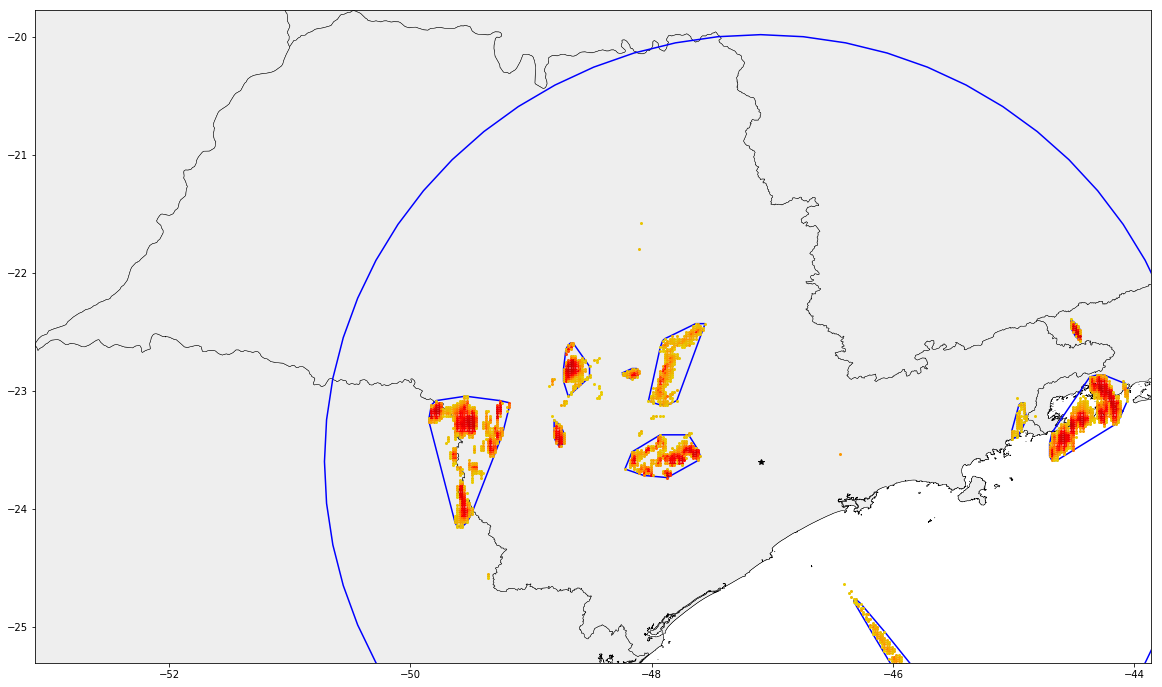

10.875558853149414


In [47]:
'''
    Redemet = 250km, IPMet = 450km
    SaoRoque: -23.599125, -47.098079
    Bauru: -22.358320, -49.027717
    Pres. Pru.: -22.175117, -51.374331
    Valores Graus em Metros para -23°:
    https://msi.nga.mil/msisitecontent/staticfiles/calculators/degree.html
    Lat = 110744
    Lon = 102523

    lat = 0 -> 1°lonDistance = 111319m

    Raio do Buffer = 99,919687401213%
'''

from math import cos
from math import radians as rad
from PIL import Image, ImageFilter
import numpy as np
import time

from sklearn.cluster import DBSCAN
import shapefile
from matplotlib.patches import Polygon as poli

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry import Polygon
from shapely.geometry import Point
start = time.time()
#Pegar localizaçao do Radar(lat,lon)
radarSR = [-23.599125, -47.098079]
radarBU = [-22.358320, -49.027717]
radarDN = [-22.175117, -51.374331]

#Pegar raio de cobertura do radar(metros ou km)
radiusRM = 400000
radiusIP = 450000

#converter raio em delta(lat e lon)
#deltaLon = cos(rad(-23))*111319
deltaLon = radiusRM/102523
deltaLat = radiusRM/110744

#Somar delta(lat/lon) com posiçao pra achar o lat/lon max. O oposto pro min
minLon = radarSR[1]-deltaLon
maxLon = radarSR[1]+deltaLon

minLat = radarSR[0]-deltaLat
maxLat = radarSR[0]+deltaLat
#Criar uma matriz que vai de MIN até MAX com skip de (MAX-MIN)/(# pixels da img)
#Importar imagem
imgMpl = mpimg.imread('radar_img/last_redemet.png')
imgPil = Image.open('radar_img/last_redemet.png')

nPoints = imgPil.size[0]

lats = np.linspace(maxLat, minLat, nPoints)
lons = np.linspace(minLon, maxLon, nPoints)
coords = np.array(np.meshgrid(lats, lons)).swapaxes(0,2)

end = time.time()
print(end-start)
#Ler cada pixel e saber o que to lendo

start = time.time()
imgMpl = np.array(imgMpl)

#print(np.unique(imgMpl.reshape(-1, imgMpl.shape[2]), axis=0))

#Filta azul claro, vazios e azuis
filterCoords = coords[np.invert(np.all(imgMpl, axis=2))]
filterPixels = imgMpl[np.invert(np.all(imgMpl, axis=2))]

filterCoords = filterCoords[np.any(filterPixels, axis=1)]
filterPixels = filterPixels[np.any(filterPixels, axis=1)]

filterCoords = filterCoords[filterPixels[:,0]>filterPixels[:,1]]
filterPixels = filterPixels[filterPixels[:,0]>filterPixels[:,1]]

filterCoords = filterCoords[filterPixels[:,1]<=0.8]
filterPixels = filterPixels[filterPixels[:,1]<=0.8]

db = DBSCAN(eps=0.09, min_samples=10).fit(filterCoords)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique_labels = set(labels)
print(unique_labels)

end = time.time()
print(end-start)
print (filterPixels.shape)

#Abre os arquivos shapefile do BR
fname2 = 'gadm/gadm36_BRA_2.shp'
fname1 = 'gadm/gadm36_BRA_1.shp'
fname0 = 'gadm/BRMUE250GC_SIR.shp'


sf = shapefile.Reader(fname0)
sfBr = shapefile.Reader(fname1)
shapes = sf.shapes()

#Cluester em DBSCAN dos pontos. de 1400 foi pra 160
'''db = DBSCAN(eps=0.09, min_samples=10).fit(coordArray)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique_labels = set(labels)'''


fig, ax = plt.subplots(figsize=(20,12))
#Projecao do mapa
states = sfBr.shapes()
a,b,c,d = states[24].bbox
plt.xlim(a,c)
plt.ylim(b,d)
for state in states:    
    shapePatch(state, '#EEEEEE')
    
start = time.time()

for k in unique_labels:
    class_member_mask = (labels == k)
    if k != -1:
#----Aki sao os clusters. Usa um centroid como base e faz o buffer que cobre uma area
        xy = filterCoords[class_member_mask & core_samples_mask]
        hull = ConvexHull(xy)
        TS = Polygon(xy[hull.vertices])
        X, Y = TS.exterior.coords.xy
        ax.plot(Y, X,'b')

                
                
for latlon, rgb in zip(filterCoords[:], filterPixels[:]):
    Y = latlon[0]
    X = latlon[1]
    ax.plot(X, Y, 'o',color=rgb, markersize=2)
end = time.time()
print(end-start)
raio = radiusRM
r_d = raio/110744
buffer_ratio = (r_d)*(1-0.99919687401213+1) #Variavel que converte buffer em metros

Y, X = radarSR
plt.plot(X,Y,'k*')
TS = Point(X,Y).buffer(buffer_ratio)
X, Y = TS.exterior.coords.xy
ax.plot(X,Y,'b')

start = time.time()
plt.show()
end = time.time()
print(end-start)

CONVERÇAO DE IMAGEM PRA POSICAO

(494, 588, 3)
(494, 588, 3)


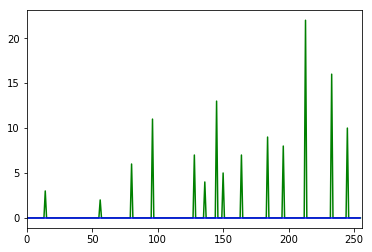

In [10]:
import numpy as np
import cv2
from PIL import Image, ImageFilter



img = Image.open('radar_img/last_ipmet.gif',)
img.save("radar_img/last_ipmet.tiff",'tiff', optimize=True, quality=100)

src_filename ='radar_img/last_ipmet.tiff' 
dst_filename = 'radar_img/dest.tiff'

img4=np.array(img.convert('RGB'))
print(img4.shape)
img2 = cv2.imread(src_filename)
print (img2.shape)
img5=img2-img4

img3 = cv2.imread('radar_img/last_ipmet.gif')
color=('r', 'g', 'b')
for i, col in enumerate(color):
    hist = cv2.calcHist([img5],[i],None,[256],[110,256])
    plt.plot(hist,color=col)
    plt.xlim([0,256])
plt.show()


In [ ]:

# Opens source dataset
src_ds = gdal.Open(src_filename)
print(src_ds.GetProjection())
format = "GTiff"
driver = gdal.GetDriverByName(format)

# Open destination dataset
dst_ds = driver.CreateCopy(dst_filename, src_ds, 0)

# Specify raster location through geotransform array
# (uperleftx, scalex, skewx, uperlefty, skewy, scaley)
# Scale = size of one pixel in units of raster projection
# this example below assumes 100x100
gt = [-7916400, 100, 0, 5210940, 0, -100]

# Set location
dst_ds.SetGeoTransform(gt)

# Get raster projection
epsg = 3857
srs = osr.SpatialReference()
srs.ImportFromEPSG(epsg)
dest_wkt = srs.ExportToWkt()

# Set projection
dst_ds.SetProjection(dest_wkt)

# Close files
dst_ds = None
src_ds = None
#image1 = cv2.imread("local.gif")
#cv2.imshow('image',image1)
#Redemet
#tamanho da imagem. px
#Tamanho da imagem. km
#Posiçao do Centro. lat/lon
# 1km = 0.008 lat
# (n km/40000) * 360
#Criar quadrado com 500km de largura = PosX e Y da imagem




#image3 = image1 - image2j

#NAME_1 = Estado
#NAME_2 = Cidade

DOWNLOAD DE IMAGEM DE RADAR DO REDEMET

In [7]:

import datetime
from datetime import timedelta
from PIL import Image, ImageFilter
import urllib.request

now_utc = datetime.datetime.utcnow()
utc_min = now_utc.strftime("%M")
print(utc_min)

if int(utc_min)<6:
    now_utc = now_utc - timedelta(minutes = 10)
    
utc_ano = now_utc.strftime("%Y")
utc_mes = now_utc.strftime("%m")
utc_dia = now_utc.strftime("%d")
utc_hora = now_utc.strftime("%H")
utc_min = now_utc.strftime("%M")
new_min = (int(int(utc_min)/10)*10)+6

print(utc_min)
print(new_min)
if (int(utc_min)-new_min)>0:
    new_min = new_min - 10
print(new_min)

url_redemet = "https://www.redemet.aer.mil.br/radar/"+utc_ano+"/"+utc_mes+"/"+utc_dia+"/sr/maxcappi/maps/"
print (now_utc)
print (url_redemet)
flag = 0
'''for h in range(now_utc.hour, now_utc.hour-2, -1):
for m in range(56, 0 , -10):'''
for s in range (10,16,1):
    if (flag == 0):
        try:
            #last_redemet = now_utc.strftime("%Y-%m-%d--")+str(h).zfill(2)+":"+str(m).zfill(2)+":"+str(s).zfill(2)+".png"
            last_redemet = now_utc.strftime("%Y-%m-%d--")+str(utc_hora).zfill(2)+":"+str(new_min).zfill(2)+":"+str(s).zfill(2)+".png"
            urllib.request.urlretrieve(url_redemet+last_redemet, 'radar_img/last_redemet.png')
            urllib.request.urlretrieve(url_redemet+last_redemet, now_utc.strftime('radar_img/'+str(h).zfill(2)+str(m).zfill(2)+'.png'))
            flag = 1
            print (last_redemet)
            break
        except:
            print('deu ruim '+ last_redemet)
            pass

colourImg = Image.open("radar_img/last_redemet.png")


56
56
56
56
2019-01-28 20:56:56.456473
https://www.redemet.aer.mil.br/radar/2019/01/28/sr/maxcappi/maps/
deu ruim 2019-01-28--20:56:10.png
deu ruim 2019-01-28--20:56:11.png
deu ruim 2019-01-28--20:56:12.png
deu ruim 2019-01-28--20:56:13.png
deu ruim 2019-01-28--20:56:14.png
deu ruim 2019-01-28--20:56:15.png
